In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
#import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u

In [6]:
nside = 512
lmax = 3*nside

In [7]:
comp = "IQU"

In [8]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [9]:
spectra_components = ["TT", "EE", "BB"]

change this to True   if you want to  run namaster on notebook 


In [10]:
namaster_on_nb = False

In [11]:
datadir=Path("/global/cscratch1/sd/giuspugl/extending_synch/data")


In [12]:
imapfile = datadir /"haslam408_dsds_Remazeilles2014.fits"
qumapfile =datadir /"wmap_band_iqumap_r9_9yr_K_v5.fits"

In [13]:
if not imapfile.exists():
    !wget -O $imapfile   https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/haslam408_dsds_Remazeilles2014.fits

In [14]:
if not qumapfile.exists():
    !wget -O $qumapfile   https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/raw/wmap_band_iqumap_r9_9yr_K_v5.fits 

In [15]:
imap = hp.read_map(imapfile) 
qumap = hp.read_map(qumapfile, field=[1,2] ) 


# Setting the inputs 
## Synchrotron   maps 
- We use the Haslam map at 408MHz for the intensity template 
- for Q and U we adopt maps from the K-band of WMAP .  


- rescaling Haslam map to 23 GHz **assuming a constant spectral index =-3.1**   and from K to uK 
- converting Wmap maps to from mK to uK  
- we reduce noise by smoothing to 2 deg 



In [16]:
rescaling_factor =  (23. / 0.408) **  -3.1 

imap *=rescaling_factor 
imap <<= u.K_RJ
imap =imap.to(    u.uK_RJ )
qumap <<= u.mK_RJ 
qumap = qumap.to("uK_RJ") 

In [17]:
IQU =np.array([ imap, qumap[0], qumap[1]] ) 


In [18]:
FWHM_SMOOTHING=2 #deg 
IQU = hp.smoothing( IQU , fwhm=np.radians(FWHM_SMOOTHING))
IQU<<= u.uK_RJ 

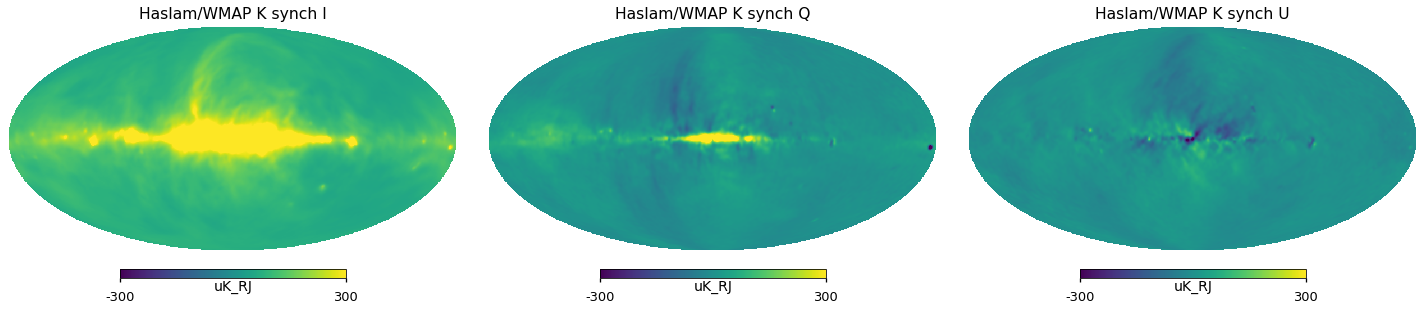

In [19]:
plt.figure(figsize=(20, 5))
for i_pol, pol in components:
    hp.mollview(
        IQU[i_pol],
        title="Haslam/WMAP K synch " + pol,
        sub=131 + i_pol,
        unit=IQU.unit,
        min=-300,
        max=300,
    )

In [20]:
if not os.path.exists(datadir/"synch_hybrid.fits") : 
    hp.write_map(datadir/"synch_hybrid.fits", IQU)

In [21]:
import numpy as np
import healpy as hp



def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i =np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))


In [22]:
iqu = map_to_log_pol_tens(IQU  .value)

<ipython-input-21-22da87ac96b7>:9: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
<ipython-input-21-22da87ac96b7>:10: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


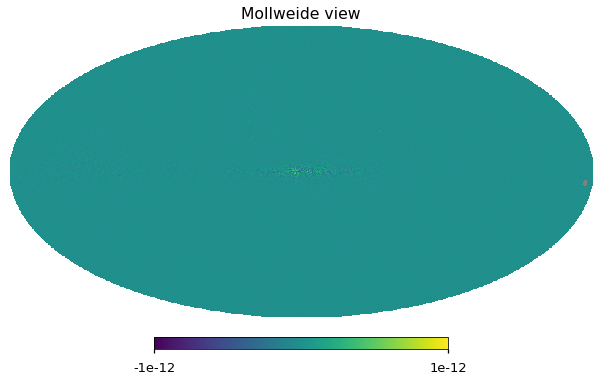

In [23]:
m_back   = log_pol_tens_to_map(iqu ) 
hp.mollview( (IQU.value  - m_back )[1], min=-1e-12,max=1e-12 )
del m_back 

In [24]:
print(f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps ")
for i in range(3 ):
    iqu[i, np.isnan(iqu[i] )] = np.nanmedian(iqu[i] )
assert np.isnan(iqu).sum() == 0
print(f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps ")

527 pixels out of 3145728 are NaNs in Log Pol Tens maps 
0 pixels out of 3145728 are NaNs in Log Pol Tens maps 


In [25]:
if not os.path.exists(datadir/"synch_logpoltens.fits") : 
    hp.write_map(datadir/"synch_logpoltens.fits", iqu)

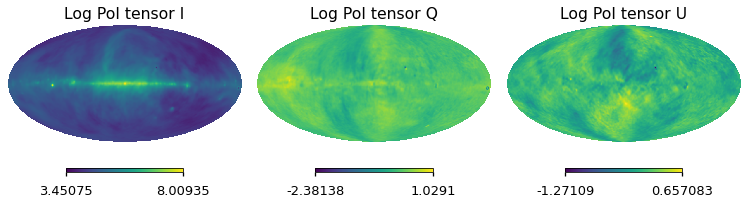

In [26]:
for i_pol, pol in components:
    hp.mollview(iqu[i_pol], title="Log Pol tensor "+pol , sub=131+i_pol   )

In [27]:
from scipy.optimize import curve_fit

In [28]:
def model(ell, A, gamma):
    out = A * ell ** gamma
    out[:2] = 0
    return out

In [29]:
def run_anafast(m, lmax) : 
    clanaf=hp.anafast(m , lmax=lmax ) 
    cl ={} 
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2 ]
    ell = np.arange(lmax +1 ) 
    
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell,cl_norm, cl     



def run_namaster(m, mask, lmax):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """
    nside = hp.npix2nside(len(mask))

    binning = nmt.NmtBin(nside=nside, nlb=1, lmax=lmax, is_Dell=False)

    cl = {}

    f_0 = nmt.NmtField(mask, [m[0] ])

    if len(m) == 3:
        f_2 = nmt.NmtField(mask, m[1:].copy())  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [30]:
print ("run anafast on masked sky  ")
ell,cl_norm,cl=run_anafast(iqu ,lmax)    

run anafast on masked sky  


## Power law fit 

- We fit in$\ell \in[1-,36]$ a power law for TT spectrum of the logpol tens i map
- we use the spectral index power law also for EE and BB power spectra to avoid unphysical crossings of EE over TT and BB over TT at higher multipoles


B-to-E ratio at l= 36 , 0.5411971656748268
B-to-E ratio at l= 36 , 0.4224581922931603


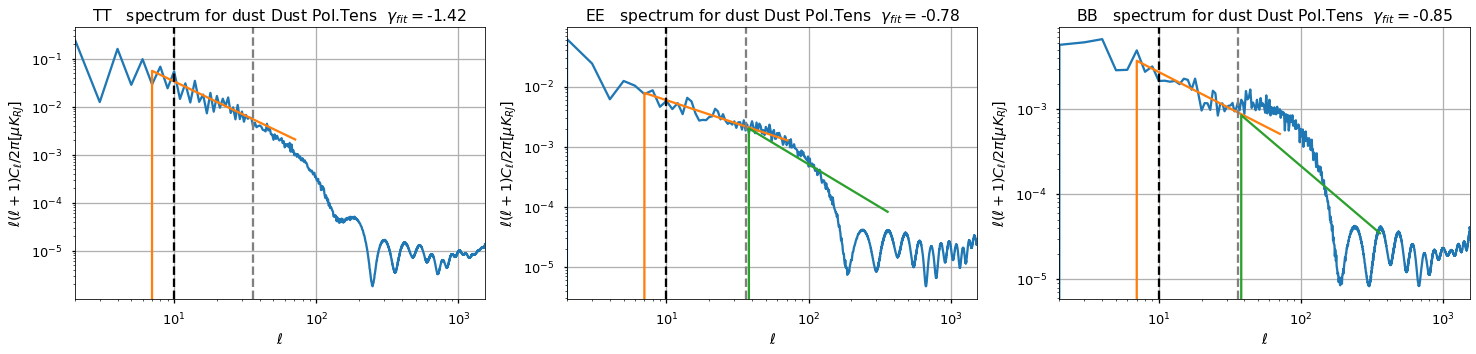

In [31]:
ell_fit_low = {"TT":10, "EE":10, "BB":10}
ell_fit_high = {"TT":36, "EE":36, "BB":36}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
plt.figure(figsize=(25,5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))

    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="Anafast $C_\ell$")

    plt.plot(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], 
             model(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], A_fit[pol], gamma_fit[pol]), label="old model fit")
    

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.grid()
    plt.title(f"{pol}   spectrum for dust Dust Pol.Tens  "+r"$\gamma_{fit}=$"+f"{gamma_fit[pol]:.2f}")

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    
print(f"B-to-E ratio at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}" ) 

for ii, pol in enumerate(spectra_components[1:] ):
    #we change the EE and BB power laws 
    A_fit[pol] =A_fit[pol]*  ell_fit_high[pol]**( gamma_fit[pol ] - gamma_fit['TT' ] ) 
    gamma_fit[pol] = gamma_fit['TT'] 
    plt.subplot(132+ii)
    plt.plot(ell[ell_fit_high[pol] :ell_fit_high[pol]*10], 
             model(ell[ell_fit_high[pol]:ell_fit_high[pol]*10], A_fit[pol], gamma_fit[pol]), label="new power law")
    
print(f"B-to-E ratio at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}" ) 
     


### Define Modulation maps 
as suggested by Ben Thorne , 
the injected small scales are at different multipoles for intensity and polarization, we consider 2 different modulation maps  

#### Modulation for  polarization : 
- smooth `i` map to 5 deg 
- we saturate all the pixels >5.5 to 1.5 
- reduce the dynamic range to range from .5 to 1.5 with MinMax rescaling  

#### Modulation for  intensity : 
- smooth `i` map to 5 deg 
- for  the pixels >5  MinMax rescaling from 1.1 to 2 
- elsewhere MinMax rescaling  from  .1 to 1.1   

In [32]:
ismooth = hp.smoothing(iqu[0] , fwhm=np.radians( 5) ) 

In [33]:
minmax= lambda m,a,b: a + (b-a) * (m - m .min()  )/(m .max() -m .min () )

modulate_amp_pol= (ismooth )*1. 
modulate_amp= (ismooth )*1. 

mskmd = ismooth > 5.5
b1=1.5
a=.5

modulate_amp_pol[mskmd] = 1.5
modulate_amp_pol[~mskmd] = minmax (ismooth[~mskmd], .5, 1.5 )
mskmd = ismooth > 5

modulate_amp[mskmd] = minmax (ismooth[mskmd], 1.1, 2 )
modulate_amp[~mskmd] = minmax (ismooth[~mskmd], .1, 1.1 )


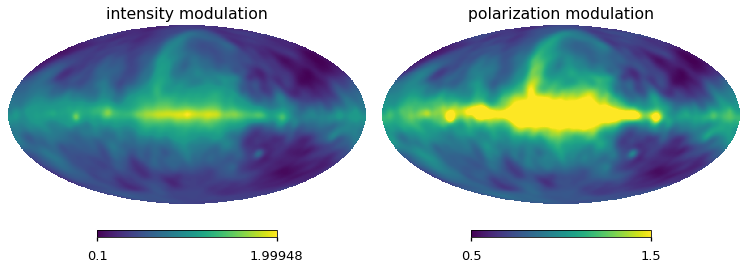

In [34]:
hp.mollview(modulate_amp, title='intensity modulation', sub=121)
hp.mollview(modulate_amp_pol, title='polarization modulation', sub=122)


In [35]:
np.random.seed(777)
#filter small scales 
small_scales_input_cl = [
    1 \
    * model(ell, A_fit[pol], gamma_fit[pol]) \
    * sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol]/10)  \
    / cl_norm \
    for pol in spectra_components
]
ii_SS_alm =hp.synalm(small_scales_input_cl+ [np. zeros_like(small_scales_input_cl[0])]*3 ,lmax=lmax, new=True )
#filter large scales 
alm_log_pol_tens_fullsky = hp.map2alm(iqu   , lmax=lmax, use_pixel_weights=True)
ii_LS_alm=np.empty_like(alm_log_pol_tens_fullsky)

for ii, pol in enumerate(spectra_components ):
    
    sig_func =  sigmoid(ell, x0= ell_fit_high[pol], width= ell_fit_high[pol]/10)
    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii] , (1.-sig_func)**.2 ) 

log_ss =hp.alm2map( ii_SS_alm , nside=nside ) 
log_ss[0] *=modulate_amp 
log_ss[1:] *=modulate_amp_pol

log_ls =hp.alm2map(ii_LS_alm, nside=nside ) 
ii_map_out = log_ss + log_ls 
 

<ipython-input-28-e2b761b15d12>:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


In [36]:
ell,cl_norm,cltot  =run_anafast(ii_map_out ,lmax)    


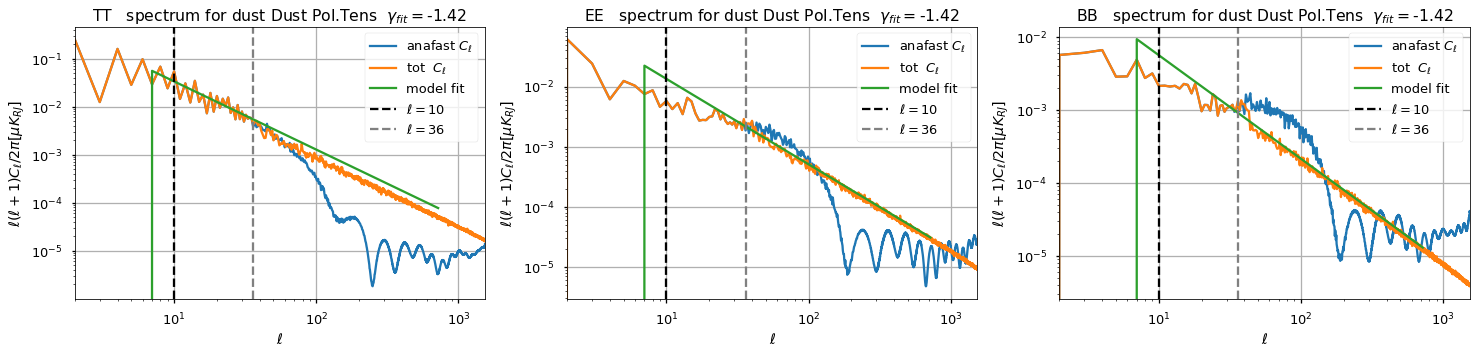

In [37]:
plt.figure(figsize=(25,5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="anafast $C_\ell$")
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cltot[pol], label="tot  $C_\ell$")

    plt.plot(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*20], 
             model(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*20], A_fit[pol], gamma_fit[pol]), label="model fit")
    

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol}   spectrum for dust Dust Pol.Tens  "+r"$\gamma_{fit}=$"+f"{gamma_fit[pol]:.2f}")

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)


In [38]:
output_map = log_pol_tens_to_map(ii_map_out )


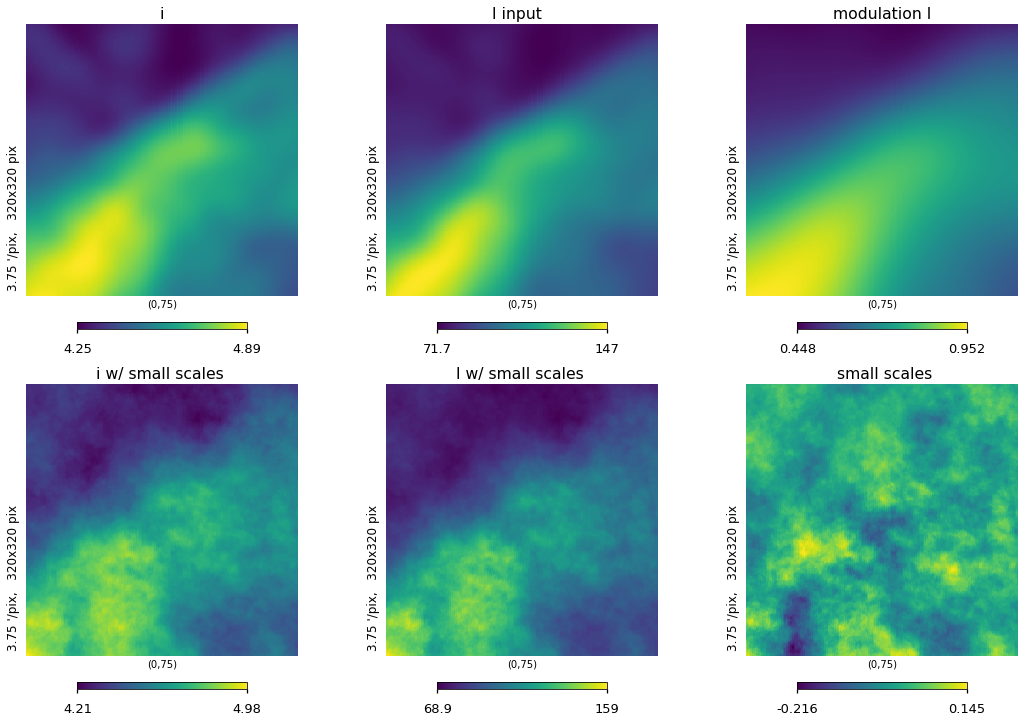

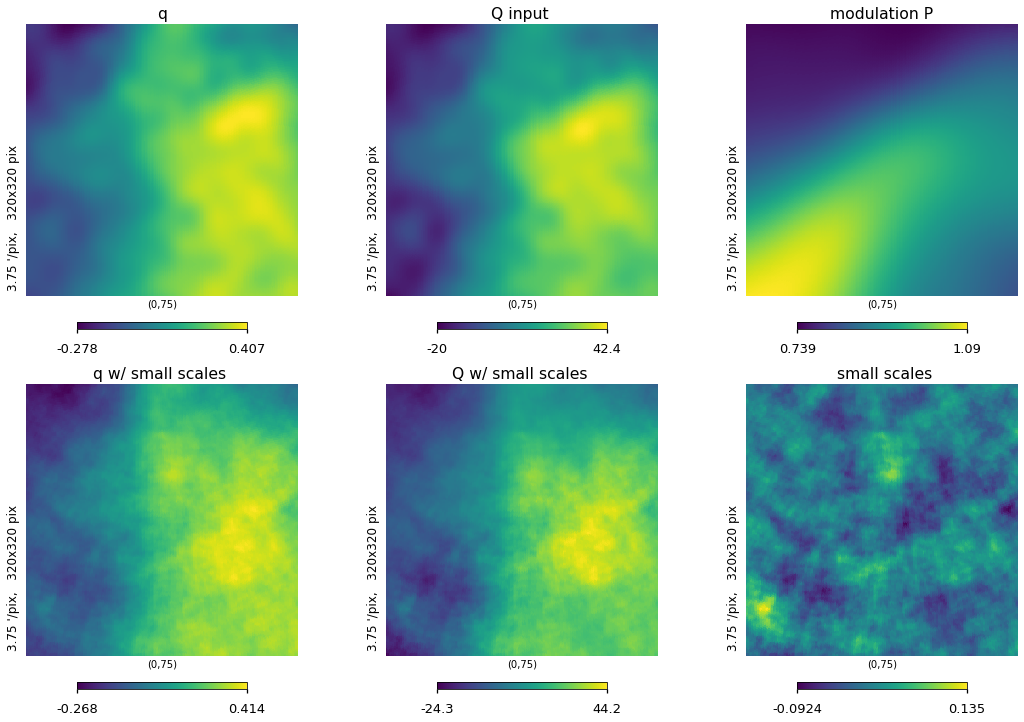

In [39]:
lat=75
plt.figure(figsize=(15,10))
hp.gnomview(ii_map_out[0] ,  title='i w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=234 )
hp.gnomview(iqu[0] ,  title='i', rot=[0,lat],reso=3.75,xsize=320, sub=231 )
hp.gnomview(modulate_amp   ,  title=' modulation I ', rot=[0,lat],reso=3.75,xsize=320,  sub=233, )

hp.gnomview((IQU[0]),  title=' I input   ', rot=[0,lat],reso=3.75,xsize=320,  sub=232, )
hp.gnomview((log_ss)[0],  title='  small scales ', rot=[0,lat], reso=3.75,xsize=320, sub=236, )
hp.gnomview(output_map[0] ,  title='I w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=235 )
lat=75
plt.figure(figsize=(15,10))
hp.gnomview(ii_map_out[1] ,  title='q w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=234 )
hp.gnomview(iqu [1],  title='q', rot=[0,lat],reso=3.75,xsize=320, sub=231 )
hp.gnomview((modulate_amp_pol ),  title=' modulation P ', rot=[0,lat],reso=3.75,xsize=320,  sub=233, )

hp.gnomview((IQU[1] ),  title=' Q input  ', rot=[0,lat],reso=3.75,xsize=320,  sub=232, )
hp.gnomview((log_ss)[1],  title='  small scales ', rot=[0,lat], reso=3.75,xsize=320, sub=236, )
hp.gnomview(output_map[1] ,  title='Q w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=235 )

In [40]:
if not os.path.exists(datadir/"sync_hybrid_out.fits"  ) : 
    hp.write_map(datadir/"sync_hybrid_out.fits", output_map  ,overwrite=True )

### Validation 


In [41]:
planck_masks = {"gal080":hp.read_map(datadir/ "HFI_Mask_GalPlane-apo2deg_512_R2.00_GAL080.fits"),
               "gal040":hp.read_map(datadir/"HFI_Mask_GalPlane-apo2_512_R2.00_GAL040.fits"),
               "gal020":hp.read_map(datadir/ "HFI_Mask_GalPlane-apo2_512_R2.00_GAL020.fits"),
               "BK":hp.read_map(datadir/ "BK15_region_Gal_apo.fits")}

planck_masks ={ k:    np.ma.masked_equal(m ,  1 ).mask  for k,m in planck_masks.items() } 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  


No handles with labels found to put in legend.
No handles with labels found to put in legend.


read Namaster spectra  
read Namaster spectra  


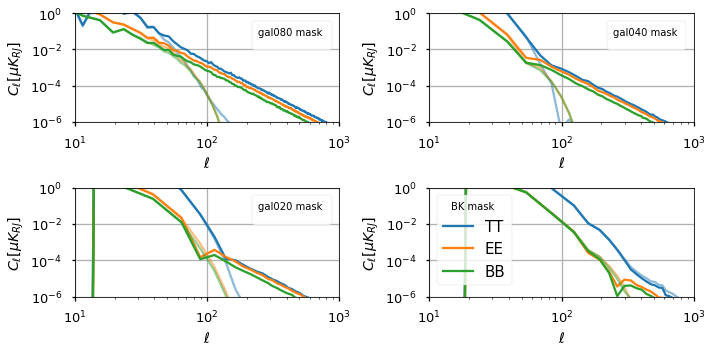

In [69]:
plt.figure(figsize=(10,5))

for jj, k in enumerate(planck_masks.keys())  :
    fspectra = datadir / f"sync_hybrid_out_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        output_ell, output_cl_norm, cl_out = run_namaster(
            output_map, mask=planck_masks[k]  , lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=output_ell, cl_norm=output_cl_norm, **cl_out)        
        
    fspectra = datadir / f"synch_hybrid_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        input_ell = np.load(fspectra)["ell"]
        cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        input_ell, input_cl_norm, cl_in  = run_namaster(
            m_planck_varres, mask=planck_masks[k], lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=input_ell, cl_norm=input_cl_norm, **cl_in)        
    plt.subplot(2,2,jj+1 )
    for ii, pol in enumerate(["TT","EE", "BB" ]):
        if jj==3:

            plt.loglog(output_ell,  abs(cl_out [pol]),   color='C%d'%ii,   label=pol
                 )
        else: 
            plt.loglog(output_ell, abs( cl_out [pol]),   color='C%d'%ii, )             
        plt.loglog(input_ell,  abs( cl_in [pol]), color='C%d'%ii,alpha=.5,)

        plt.grid()
        plt.legend(title=(k +" mask "), fontsize=15)  
        plt.ylabel("$ C_\ell  [\mu K_{RJ}]$")
        plt.xlabel(("$\ell$"))
        plt.xlim(10,1e3) 
        plt.ylim(1e-6,1e0) 
plt.tight_layout() 

<ipython-input-71-dcfbeb419477>:35: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
<ipython-input-71-dcfbeb419477>:36: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
No handles with labels found to put in legend.
<ipython-input-71-dcfbeb419477>:35: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
<ipython-input-71-dcfbeb419477>:36: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
No handles with labels found to put in legend.
<ipython-input-71-dcfbeb419477>:35: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
<ipython-input-71-dcfbeb419477>:36: RuntimeWarnin

read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  


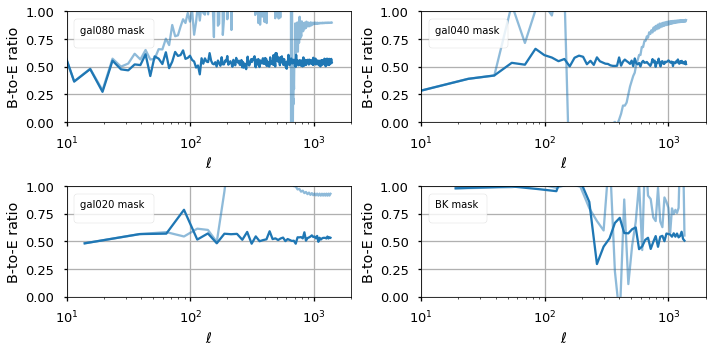

In [71]:
plt.figure(figsize=(10,5))

for jj, k in enumerate(planck_masks.keys())  :
    fspectra = datadir / f"sync_hybrid_out_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        output_ell, output_cl_norm, cl_out = run_namaster(
            output_map, mask=planck_masks[k], lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=output_ell, cl_norm=output_cl_norm, **cl_out)        
        
    #else:
    #    print("run anafast on masked sky  ")
    #    output_ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
    
    fspectra = datadir / f"synch_hybrid_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        input_ell = np.load(fspectra)["ell"]
        cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        input_ell, input_cl_norm, cl_in  = run_namaster(
            m_planck_varres, mask=planck_masks[k], lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=input_ell, cl_norm=input_cl_norm, **cl_in)        
    #else:
    #    print("run anafast on masked sky  ")
    #    ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
    plt.subplot(2,2,jj+1 )
    plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
    plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
    plt.grid()
    plt.legend(title=(k +" mask "), fontsize=15)  
    plt.ylabel(("B-to-E ratio"))
    plt.xlabel(("$\ell$"))
    plt.ylim(0,1) 
    plt.xlim(10,2e3 ) 
    
plt.tight_layout() 

In [45]:
get_polfrac = lambda m: np.sqrt(m[1] ** 2 + m[2] ** 2) / m[0]

In [46]:
Pout = get_polfrac(output_map)
Pin = get_polfrac(IQU.value)

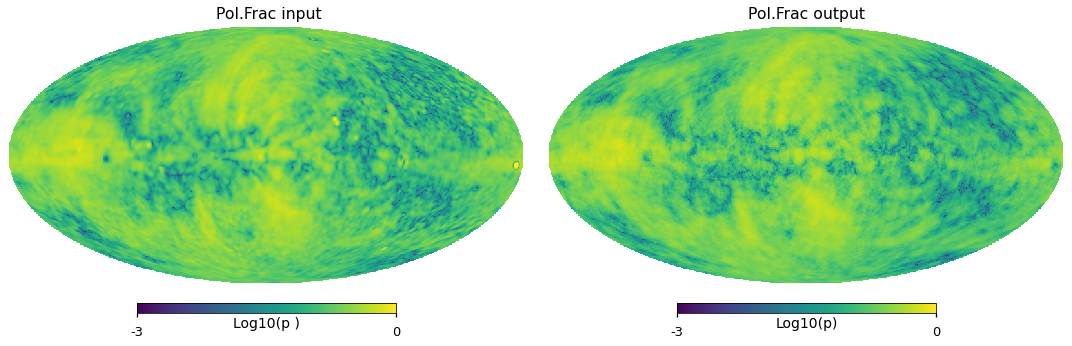

In [47]:
plt.figure(figsize=(15, 5))
hp.mollview(
    np.log10(Pin), title=" Pol.Frac input", sub=121, min=-3, max=0, unit="Log10(p )"
)
hp.mollview(
    np.log10(Pout), title="Pol.Frac output", sub=122, min=-3, max=0, unit="Log10(p)"
)

In [48]:
logpin = np.log10(Pin)
logpout = np.log10(Pout)

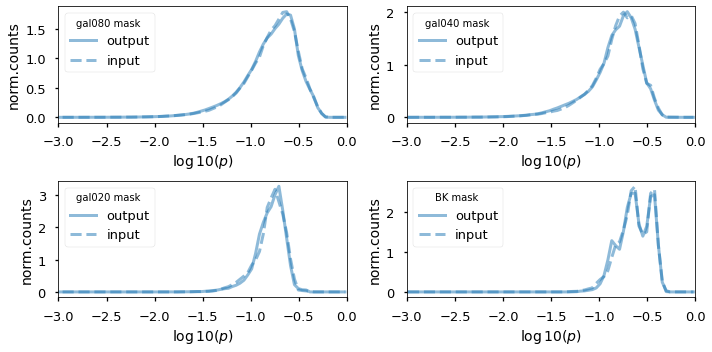

In [49]:
plt.figure(figsize=(10,5))

for jj,pm  in enumerate(planck_masks.items())  :
    k =pm[0]
    msk =pm[1] 
    
    plt.subplot(2,2,jj+1 )
    

    h,edg= np.histogram(
        logpout[msk] ,
        bins=np.linspace(-4, 0, 100), density=True)
    xb = np.array([(edg[i] +edg[i+1])/2 for i in range(edg.size-1)])
    
    plt.plot( xb,h,
        lw=3,
       color='C0', alpha=.5,label='output'

    )
    h, edg= np.histogram(
        logpin[msk] ,
        density=True ,
        bins=np.linspace(-4, 0, 100))  
    xb = np.array([(edg[i] +edg[i+1])/2 for i in range(edg.size-1)])
    
    plt.plot(xb,h , 
        lw=3,alpha=.5 ,color='C0' ,linestyle='--',label='input'
    )
    plt.ylabel("norm.counts", fontsize=14)
    plt.xlabel(r"$\log10( p )$", fontsize=14)
    plt.legend(title=(k +" mask "), fontsize=13, loc='best' )  
    plt.xlim(-3,-0.)         
plt.tight_layout() 


###  Small scales on the PySM2 beta synchrotron template

- we subtract the offset term from the $\beta_s$ map  
- we use the fitted power law from the study of Nicoletta to inject small scales on to the Bs map
- we rescale the large scale Bs map by a factor `~1.572` which comes from the SPASS latest results 
- we modulate the small scales on the Bs map by the same  modulation map adopted for intensity  



In [51]:

template_dir = '/global/project/projectdirs/cmb/www/pysm-data/pysm_2/'
beta_s_pysm = hp.read_map(template_dir+'synch_beta.fits')
print(beta_s_pysm.mean())
beta_s_pysm_nomono = remove_mono(beta_s_pysm)
print(beta_s_pysm_nomono.mean())


-2.9999975418052904
1.4802973661668753e-16


In [52]:
ell = np.arange(lmax+1)
cl_spass_fit = 10**(-0.82655497)*ell**(-2.60860208)
cl_spass_fit[0] = 0

<ipython-input-73-18c60415f54f>:2: RuntimeWarning: divide by zero encountered in power
  cl_spass_fit = 10**(-0.82655497)*ell**(-2.60860208)


In [54]:
np.random.seed(777)

bs_ss_alm =hp.synalm(cl_spass_fit ,lmax=lmax )
alm_bs  = hp.map2alm(  beta_s_pysm_nomono    , lmax=lmax, use_pixel_weights=True)

bs_LS_alm=np.empty_like(alm_bs)

sig_func =  sigmoid(ell, x0= ell_fit_high['TT' ]-15, width= ell_fit_high['TT' ]/10)
bs_LS_alm= hp.almxfl(alm_bs ,  np.sqrt(1.-sig_func)) 
bs_ss_alm=  hp.almxfl(bs_ss_alm ,  np.sqrt(sig_func) ) 
bs_ss =hp.alm2map( bs_ss_alm , nside=nside ) 

bs_ss *=modulate_amp 

bs_ls =hp.alm2map(bs_LS_alm, nside=nside )
bs_ls_resc = bs_ls  * 1.5722501

In [55]:
bs_out = bs_ss *modulate_amp   + bs_ls_resc  -3.1

In [91]:
clout=hp.anafast(bs_out, lmax=lmax)
clnico=hp.anafast(beta_update, lmax=lmax)
clnicom=hp.anafast(beta_update_mod, lmax=lmax)
clin= hp.anafast(beta_s_pysm, lmax=lmax) 

(1e-10, 0.01)

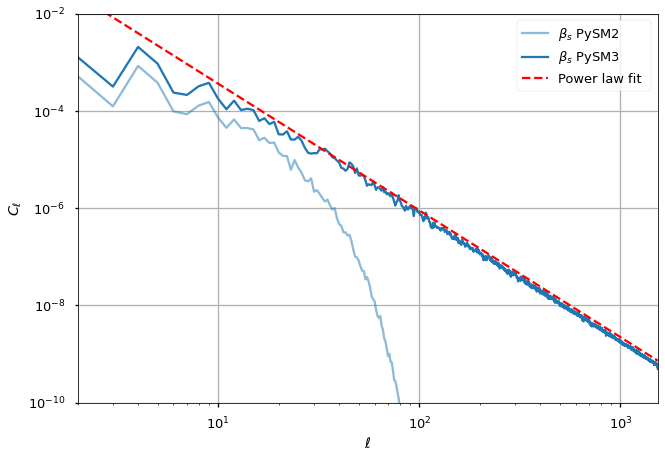

In [94]:
for ii in range(1) :
    plt.loglog(ell,  clin,  alpha=.5, color='C%d'%ii , label=r'$ \beta_s$ PySM2' )
    plt.loglog(ell,  clout, label=r"$  \beta_s$ PySM3 ",  )
        
    plt.grid(True)
    plt.plot(ell , 
             cl_spass_fit , '--' ,label='Power law fit ' , color='red' )
    
    plt.legend()
    
    plt.ylabel("$ C_\ell $")
    plt.xlabel(("$\ell$"))
    #plt.xlim(10, 55 )    
    plt.xlim(2,lmax  )
plt.ylim(1e-10, 1e-2)     

## Comparison with Nicoletta results

In [86]:
## power law  scale Bs map
np.random.seed(777)

beta_gauss = gauss_map(cl_spass_fit, nside=nside, lmax=lmax)

#filter high pass 
high_pass = high_pass_filter(np.radians(5.), lmax)
beta_gauss_filt = apply_filter(beta_gauss, high_pass, nside=nside)

#upgrade map #rescale to match Bs SPASS - this is gonna be the map w/ large scales
beta_s_pysm_ug = hp.ud_grade(beta_s_pysm_nomono, nside)
beta_update_mod = beta_s_pysm_ug * 1.5722501   + beta_gauss_filt*modulate_amp - 3.1
beta_update  = beta_s_pysm_ug * 1.5722501   + beta_gauss_filt  - 3.1


(1e-10, 0.01)

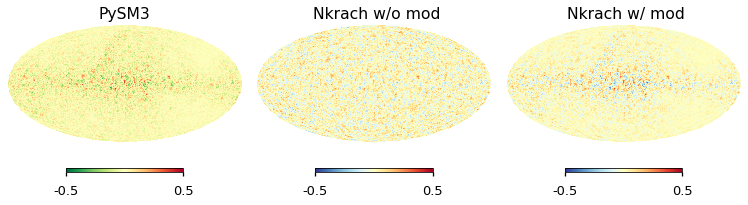

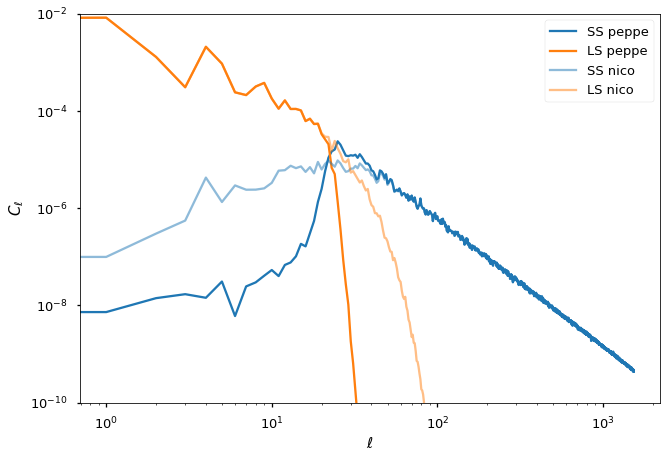

In [87]:
hp.mollview( bs_ss,sub=131,min=-.5,max=.5, title='PySM3', cmap='RdYlGn_r' ) 
hp.mollview(beta_gauss_filt*modulate_amp, sub=133,min=-.5,max=.5, title=' Nkrach w/ mod', cmap='RdYlBu_r') 
hp.mollview(beta_gauss_filt, sub=132,min=-.5,max=.5, title=' Nkrach w/o mod', cmap='RdYlBu_r') 
plt.figure()
clout=hp.anafast(bs_ss , lmax=lmax)
clnico=hp.anafast(beta_gauss_filt*modulate_amp, lmax=lmax)
clnicols=hp.anafast(beta_s_pysm_nomono* 1.5722501, lmax=lmax)
cloutls=hp.anafast(bs_ls_resc, lmax=lmax)

plt.loglog(ell, clout,label='SS peppe')
plt.loglog(ell, cloutls, label='LS peppe' )
plt.loglog(ell, clnico,alpha=.5,label='SS nico', color='C0' )
plt.loglog(ell, clnicols, alpha=.5, label='LS nico' , color='C1' )
plt.legend() 
plt.xlabel(r"$\ell$", fontsize=15) 
plt.ylabel(r"$C_{\ell}$", fontsize=15) 
plt.ylim(1e-10, 1e-2) 

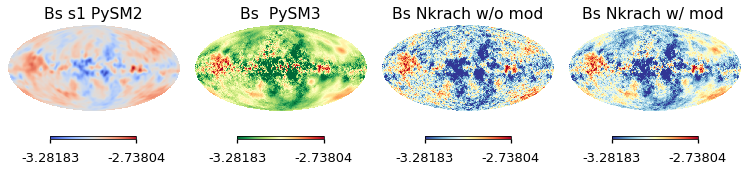

In [88]:
hp.mollview( beta_s_pysm,sub=141, title='Bs s1 PySM2' , cmap='coolwarm' , min=beta_s_pysm.min(), max=beta_s_pysm.max()) 
hp.mollview( bs_out,sub=142, title='Bs  PySM3' , cmap='RdYlGn_r' , min=beta_s_pysm.min(), max=beta_s_pysm.max()) 
hp.mollview(beta_update_mod, min=beta_s_pysm.min(), max=beta_s_pysm.max()
            , sub=144, title='Bs Nkrach w/ mod ', cmap='RdYlBu_r') 
hp.mollview(beta_update, min=beta_s_pysm.min(), max=beta_s_pysm.max()
            , sub=143, title='Bs Nkrach w/o mod', cmap='RdYlBu_r' ) 


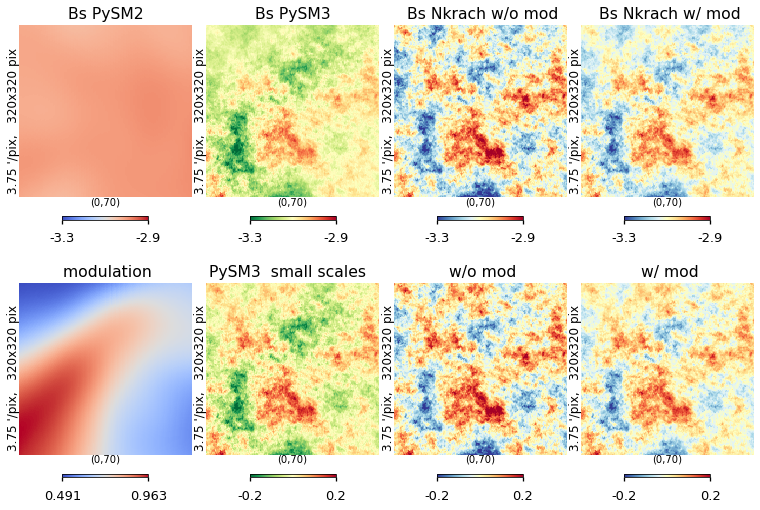

In [90]:

rot=[0,70] 
hp.gnomview( bs_out,rot=rot,min=-3.3,max=-2.9, sub=242, title='Bs PySM3' , cmap='RdYlGn_r', xsize=320, reso=3.75) 
hp.gnomview( beta_s_pysm,min=-3.3,max=-2.9 ,rot=rot, sub=241, title='Bs PySM2' , cmap='coolwarm', xsize=320, reso=3.75) 
hp.gnomview(beta_update,rot=rot,min=-3.3,max=-2.9, sub=243, title=' Bs Nkrach w/o mod', cmap='RdYlBu_r', xsize=320, reso=3.75) 
hp.gnomview(beta_update_mod,rot=rot,min=-3.3,max=-2.9, sub=244, title=' Bs Nkrach w/ mod', cmap='RdYlBu_r', xsize=320, reso=3.75) 

hp.gnomview( bs_ss ,min=-.2,max=.2, rot=rot, sub=246, title='PySM3  small scales  ', cmap='RdYlGn_r' , xsize=320, reso=3.75) 
hp.gnomview(beta_gauss_filt,min=-.2,max=.2, rot=rot, sub=247, title=' w/o mod', cmap='RdYlBu_r', xsize=320, reso=3.75) 
hp.gnomview(beta_gauss_filt*modulate_amp,min=-.2,max=.2, rot=rot, sub=248, title=' w/ mod', cmap='RdYlBu_r', xsize=320, reso=3.75) 
hp.gnomview( modulate_amp,rot=rot, sub=245, title=' modulation', cmap='coolwarm', xsize=320, reso=3.75) 

